# The Frank and Yang model

The goal here is to see what the model parameters represent and what the exact function of the error (empty) vectors are

## Parameters - 

The English stimuli consisted of 60, four word sentences presented at the rate of 4 words/second (changed in FY model to 4/s). To correspond to the 200 Hz low-pass filter frequency, every 250 ms is discretized to 5ms intervals, and at each interval, the model represents the word as an N(=300 in Google word2vec) dimensional vector. 

At each point in time, every element is represented either as a noise (mu=0,std=0.5, if t < tau), or as noise superimposed on the original vector (if t >= tau), where is tau chosen (uniform distribution, mu 40, beta=50) beforehand for each word. To account for the fact that we use a different set of word representations, we assume error to be a zero value instead of the random number obtained from the distribution described above.

And so 50 of these vectors are concatenated to get a 300x50 matrix. 

In [1]:
import os
import numpy as np
from random import shuffle
import csv
import pickle
#from dictionaries import d_words_g
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random
from pathlib import Path
import pdb
import gensim
import json

In [2]:
# Load the Ding grammatical stimuli
with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv', 'r') as f:
    sentence_list = [row for row in csv.reader(f)]
# Load the google vectors of these word stimuli - 
new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]

In [3]:
# For every word vector, get a N dimensional tau values. That is, if a wordvec = 300x1, every one of these dimensions must have
# a tau value, and for every word this tau vector must be unique.
tau_dict = {}
dim_size = new_dict.item()['NONE'].shape[0]
for sent in sentence_list:
    for w in sent:
        tau_vector = np.round(np.random.uniform(low=225,high=245,size=(dim_size,)))
        #tau_vector = np.round(np.random.uniform(low=190,high=210,size=(dim_size,)))
        #tau_vector = np.zeros((dim_size,))
        tau_vector[:] = 240
        tau_dict[w] = tau_vector

In [4]:
# for every sentence in the stimuli, expand to 50 intervals, and do what is described above
# all_sent_matrices finally contains the concatenated matrix
all_sent_matrices = []
for sent in sentence_list:
    sentence_matrix = np.zeros((dim_size,200))
    for ind,w in enumerate(sent):
        word_matrix = np.zeros((dim_size,50))
        for i in range(50):
            v_array = np.zeros((dim_size,))
            v_array.fill(i*5)
            v_mask = (v_array > tau_dict[w]) * 1.0
            word_matrix[:,i] = new_dict.item()[w] * v_mask
            #word_matrix[:,i] = random_vectors[w] * v_mask
        sentence_matrix[:,ind*50:ind*50 + 50] = word_matrix
    all_sent_matrices.append(sentence_matrix)
all_sent_matrices = np.transpose(np.concatenate(all_sent_matrices,axis=1))

In [5]:
from scipy.stats import norm
temp = np.unique(all_sent_matrices)
mu, std = norm.fit(temp)
print(mu,std)
random_vectors = {}
for sent in sentence_list:
    for w in sent:
        random_vectors[w] = np.random.normal(loc=mu,scale=std,size=(dim_size,))

-0.0024667211397123774 0.18038374285737396


In [6]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=200):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """
    #pdb.set_trace()
    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    units_ps = np.array(units_ps)
    mean_ps = np.mean(units_ps, axis=0)
    print ('mean_ps',mean_ps.shape)
    return freq, mean_ps, units_ps

In [33]:
def plot_results(plot_path, freq, power,sampling_rate=200,n_samples=60,title='Input stimuli',smoothed=True):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    # Build plot
    plt.title(title)
    hz_4 = np.where(freq == 4)[0][0]
    print(hz_4)
    plt.plot(freq[1:hz_4+50], power[1:hz_4+50], 'r', linewidth=1.0)
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Power (db)')
    # Adjusts subplot
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    #fig.savefig(plot_path+'.pdf')


freq  (601,)
mean_ps (601,)
240


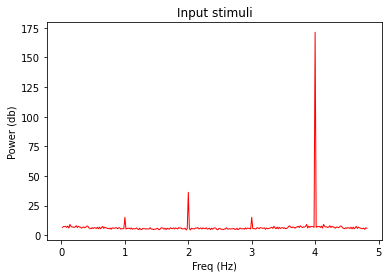

In [34]:
dim_size = 300
indices_array = [(i*10)-1 for i in range(1200)]
temp_matrix = all_sent_matrices[indices_array,:]
temp_matrix.shape
freq,mean_ps,units_ps = power_spectra(temp_matrix,sampling_rate=20)
plot_results(plot_path=None,freq=freq,power=mean_ps,sampling_rate=20)

In [28]:
all_sent_matrices[0:200,0]

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.08056641,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

freq  (6001,)
mean_ps (6001,)
600


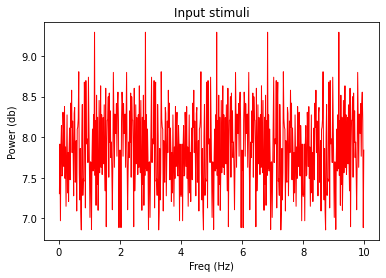

In [46]:
freq,mean_ps,units_ps = power_spectra(all_sent_matrices)
plot_results(plot_path=None,freq=freq,power=mean_ps)

## Observations : 

1. The google word2vec shows a similar 1-2-4 pattern as in the FY model, and their parameter choice is explained in S4 of the PloS one paper - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0197304#pone.0197304.s007
2. As control, with a random vector (taken from the same distribution as the google word2vec) did not show 1-2-4, but a 4Hz peak is visible when tau is increased to > 220
3. Does lexical representation of the concatenation kind "explain" the 1-2-4? Processing these lexical representations is the subject of inquiry in the RNN notebook. 